## Applying Artificial Neural Network Algorithms to the Problem (Stock Time Series Forecasting)

# HYBRID MODEL X2 v05

In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from sklearn.base import TransformerMixin, BaseEstimator
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, concatenate, Dropout, concatenate, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#xXx############################################################################################xXx#
# Function to preprocess and clean the dataset dynamically
def preprocess_data(ticker, start, end, n_timesteps=10, model_type='LSTM'):
    # Download historical data
    df = yf.download(ticker, start=start, end=end)
    
    # Preprocess the data
    df['Date'] = pd.to_datetime(df.index)
    df['Date'] = df['Date'].apply(lambda date: date.timestamp())
    
    # Remove noise and outliers
    z_scores = zscore(df[['Open', 'High', 'Low', 'Close', 'Volume']])
    df = df[(z_scores < 3).all(axis=1)]

    # Feature engineering
    df['Price_Change_Pct'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['50d_MA'] = df['Close'].rolling(window=50).mean()
    df['200d_MA'] = df['Close'].rolling(window=200).mean()

    # Technical indicators
    rsi_indicator = RSIIndicator(df['Close'], window=14)
    df['RSI'] = rsi_indicator.rsi()
    bb_indicator = BollingerBands(df['Close'], window=20)
    df['Bollinger_Bands'] = bb_indicator.bollinger_mavg()
    macd_indicator = MACD(df['Close'], window_slow=26, window_fast=12)
    df['MACD'] = macd_indicator.macd()

    # Remove NA values after feature engineering
    df = df.dropna()

    # Split the data into features and target
    X = df[['Price_Change_Pct', 'Log_Returns', '50d_MA', '200d_MA', 'RSI', 'Bollinger_Bands', 'MACD']]
    y = df['Close']

    return X, y

class ReshapeForModel(BaseEstimator, TransformerMixin):
    def __init__(self, n_timesteps=10, model_type='LSTM'):
        self.n_timesteps = n_timesteps
        self.model_type = model_type

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples, n_features = X.shape
        reshaped_data = []

        # Create rolling windows of size 'n_timesteps'
        for i in range(n_samples - self.n_timesteps + 1):
            reshaped_data.append(X[i:i + self.n_timesteps])
        
        reshaped_data = np.array(reshaped_data)

        # Do NOT add channel dimension for CNN, as Conv1D expects 3D input (n_samples, n_timesteps, n_features)
        if self.model_type == 'CNN':
            return reshaped_data  # Shape: (n_samples, n_timesteps, n_features)
        return reshaped_data  # Same for LSTM


# Dynamic pipeline for preprocessing, scaling, and reshaping
def create_dynamic_pipeline(n_timesteps=10, model_type='LSTM'):
    pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),           # Handle missing values
        ('scaler', MinMaxScaler(feature_range=(0, 1))),        # Normalize data
        ('reshape', ReshapeForModel(n_timesteps=n_timesteps, model_type=model_type))  # Reshape for model
    ])
    return pipeline

# LSTM model creation
def create_lstm_model(n_timesteps, n_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Assuming it's a regression task
    model.compile(optimizer='adam', loss='mse')
    return model

def create_cnn_model(n_timesteps, n_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(Flatten())  # Flatten the output to 1D
    model.add(Dense(50, activation='relu'))  # Dense layer with some neurons
    model.add(Dense(1))  # Output single value for regression
    model.compile(optimizer='adam', loss='mse')
    return model

# Combination
def create_hybrid_model(n_timesteps, n_features):
    # CNN branch
    cnn_input = Input(shape=(n_timesteps, n_features))
    cnn_branch = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
    cnn_branch = Flatten()(cnn_branch)  # Flatten to 2D shape (None, units)
    
    # LSTM branch
    lstm_input = Input(shape=(n_timesteps, n_features))
    lstm_branch = LSTM(50, activation='relu')(lstm_input)  # Already 2D output (None, 50)
    
    # Combine CNN and LSTM branches
    combined = concatenate([cnn_branch, lstm_branch])
    
    # Add a Dropout layer for regularization
    combined = Dropout(0.2)(combined)
    
    # Output layer (for regression)
    output = Dense(1)(combined)
    
    # Build model
    model = Model(inputs=[cnn_input, lstm_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    return model
#xXx############################################################################################xXx#

# Set up the pipeline and models
ticker = "BTC-USD"
start = "2000-01-01"
end = (datetime.today() - timedelta(days=5)).strftime("%Y-%m-%d")

# Preprocess and split the data
X, y = preprocess_data(ticker, start=start, end=end)

# Create the pipeline for LSTM
pipeline_lstm = create_dynamic_pipeline(n_timesteps=10, model_type='LSTM')
X_lstm_processed = pipeline_lstm.fit_transform(X)

# Train your LSTM model
lstm_model = create_lstm_model(n_timesteps=10, n_features=X_lstm_processed.shape[2])
lstm_model.fit(X_lstm_processed, y[9:], epochs=10, batch_size=32, verbose=0)

# Create the pipeline for CNN
pipeline_cnn = create_dynamic_pipeline(n_timesteps=10, model_type='CNN')
X_cnn_processed = pipeline_cnn.fit_transform(X)

# Train your CNN model
cnn_model = create_cnn_model(n_timesteps=10, n_features=X_cnn_processed.shape[2])
cnn_model.fit(X_cnn_processed, y[9:], epochs=10, batch_size=32, verbose=0)


[*********************100%***********************]  1 of 1 completed


In [20]:
# Ensure both have the same shape before feeding them into the hybrid model
assert X_lstm_processed.shape == X_cnn_processed.shape

# Create the hybrid model
hybrid_model = create_hybrid_model(n_timesteps=10, n_features=X.shape[1])

# Train the hybrid model
hybrid_model.fit([X_cnn_processed, X_lstm_processed], y[9:], epochs=10, batch_size=32, verbose=0)

In [21]:
# Split your data into train and test sets (if not already split)
X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_lstm_processed, y[9:], test_size=0.2, shuffle=False)

# Train your LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)

# Predict with LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Calculate scores for LSTM
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f"LSTM Model - MSE: {mse_lstm}, MAE: {mae_lstm}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM Model - MSE: 13812854.439050075, MAE: 2609.8060663437045


In [22]:
# Split your data into train and test sets for CNN
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn_processed, y[9:], test_size=0.2, shuffle=False)

# Train your CNN model
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32,verbose=0)

# Predict with CNN
y_pred_cnn = cnn_model.predict(X_test_cnn) # switch between these line of codes
#y_pred_cnn = np.squeeze(y_pred_cnn) # switch between these line of codes

# Calculate scores for CNN
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)

print(f"CNN Model - MSE: {mse_cnn}, MAE: {mae_cnn}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
CNN Model - MSE: 18103293.4339604, MAE: 2935.1470757141556


In [23]:
# Split your data into train and test sets for both LSTM and CNN inputs (hybrid)
X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_lstm_processed, y[9:], test_size=0.2, shuffle=False)
X_train_cnn, X_test_cnn, _, _ = train_test_split(X_cnn_processed, y[9:], test_size=0.2, shuffle=False)

# Train the Hybrid model
hybrid_model.fit([X_train_cnn, X_train_lstm], y_train, epochs=10, batch_size=32,verbose=0)

# Predict with the Hybrid model
y_pred_hybrid = hybrid_model.predict([X_test_cnn, X_test_lstm])

# Calculate scores for the Hybrid model
mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)

print(f"Hybrid Model - MSE: {mse_hybrid}, MAE: {mae_hybrid}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Hybrid Model - MSE: 15105188.493470341, MAE: 2691.075563477984


In [24]:
print(f"Comparison of Models:")
print(f"LSTM Model - MSE: {mse_lstm}, MAE: {mae_lstm}")
print(f"CNN Model - MSE: {mse_cnn}, MAE: {mae_cnn}")
print(f"Hybrid Model - MSE: {mse_hybrid}, MAE: {mae_hybrid}")

Comparison of Models:
LSTM Model - MSE: 13812854.439050075, MAE: 2609.8060663437045
CNN Model - MSE: 18103293.4339604, MAE: 2935.1470757141556
Hybrid Model - MSE: 15105188.493470341, MAE: 2691.075563477984


In [25]:
from sklearn.metrics import r2_score

r2_lstm = r2_score(y_test, y_pred_lstm)
r2_cnn = r2_score(y_test, y_pred_cnn)
r2_hybrid = r2_score(y_test, y_pred_hybrid)

print(f"LSTM Model - R2: {r2_lstm}")
print(f"CNN Model - R2: {r2_cnn}")
print(f"Hybrid Model - R2: {r2_hybrid}")

LSTM Model - R2: 0.9555132226549754
CNN Model - R2: 0.94169509367076
Hybrid Model - R2: 0.9513510288384784


In [26]:
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split your data for LSTM
X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_lstm_processed, y[9:], test_size=0.2, shuffle=False)

# Train your LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)

# Predict with LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Calculate scores for LSTM
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM Model - MSE: {mse_lstm}, MAE: {mae_lstm}, R2: {r2_lstm}")


# Split your data for CNN
X_train_cnn, X_test_cnn, _, _ = train_test_split(X_cnn_processed, y[9:], test_size=0.2, shuffle=False)

# Train your CNN model
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

# Predict with CNN
#y_pred_cnn = np.squeeze(y_pred_cnn)
y_pred_cnn = cnn_model.predict(X_test_cnn)

# Calculate scores for CNN
y_pred_cnn = np.squeeze(y_pred_cnn)
mse_cnn = np.mean((y_test - y_pred_cnn) ** 2)
mae_cnn = np.mean(np.abs(y_test - y_pred_cnn))
r2_cnn = np.corrcoef(y_test, y_pred_cnn)[0, 1] ** 2

print(f"CNN Model - MSE: {mse_cnn}, MAE: {mae_cnn}, R2: {r2_cnn}")


# Split your data for the hybrid model (both LSTM and CNN inputs)
X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_lstm_processed, y[9:], test_size=0.2, shuffle=False)
X_train_cnn, X_test_cnn, _, _ = train_test_split(X_cnn_processed, y[9:], test_size=0.2, shuffle=False)

# Train the Hybrid model
hybrid_model.fit([X_train_cnn, X_train_lstm], y_train, epochs=10, batch_size=32)

# Predict with the Hybrid model
y_pred_hybrid = hybrid_model.predict([X_test_cnn, X_test_lstm])

# Calculate scores for Hybrid model
mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)
r2_hybrid = r2_score(y_test, y_pred_hybrid)

print(f"Hybrid Model - MSE: {mse_hybrid}, MAE: {mae_hybrid}, R2: {r2_hybrid}")

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11116311.0000
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12418654.0000
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9707226.0000
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10333153.0000
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12135691.0000
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11602786.0000
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11013532.0000
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10076247.0000
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9376318.0000
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10055619.0000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model - MSE: 21837184.710248202, MAE: 3302.8544168486173, R2: 0.9296694265234149
Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11855951.0000
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10024769.0000
Epoch 3/10


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


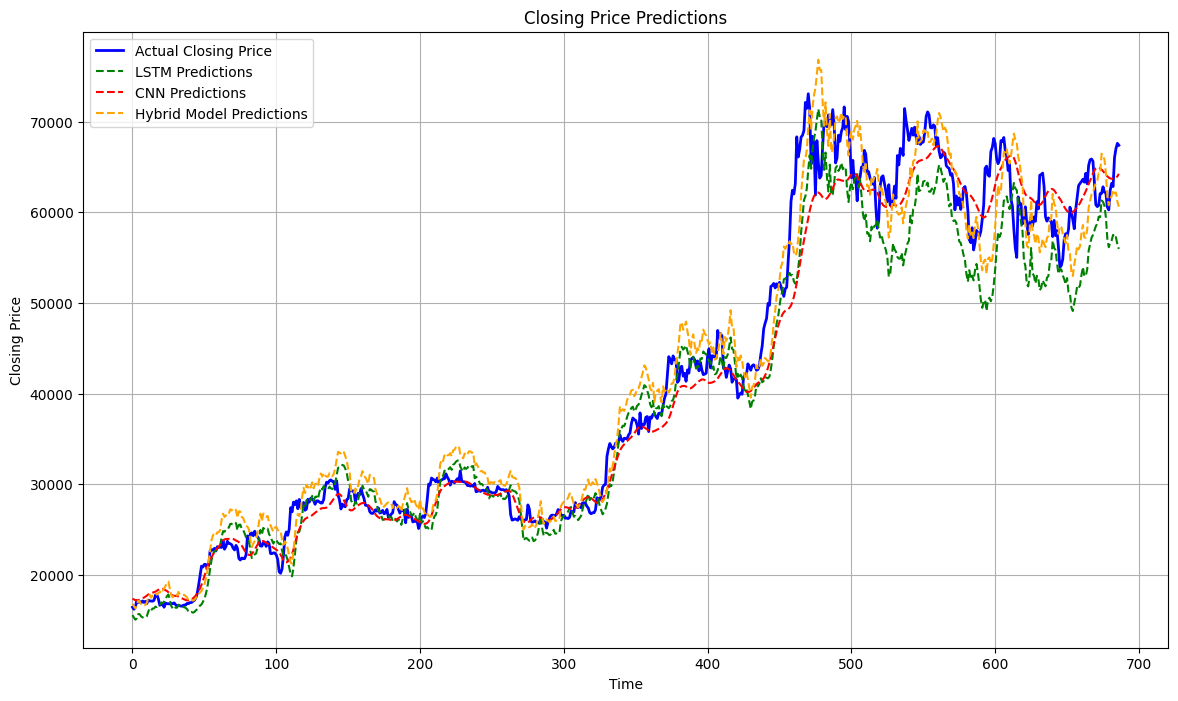

In [27]:
# Function to plot actual vs predictions
def plot_timeseries_predictions(y_test, y_pred_lstm, y_pred_cnn, y_pred_hybrid, title='Closing Price Predictions'):
    plt.figure(figsize=(14, 8))
    
    # Create a time axis based on the test set length
    time_axis = range(len(y_test))

    # Plot actual closing prices (ground truth)
    plt.plot(time_axis, y_test, label='Actual Closing Price', color='blue', linewidth=2)

    # Plot LSTM predictions
    plt.plot(time_axis, y_pred_lstm, label='LSTM Predictions', color='green', linestyle='--')

    # Plot CNN predictions
    plt.plot(time_axis, y_pred_cnn, label='CNN Predictions', color='red', linestyle='--')

    # Plot Hybrid model predictions
    plt.plot(time_axis, y_pred_hybrid, label='Hybrid Model Predictions', color='orange', linestyle='--')

    # Title and labels
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming predictions for all models are generated
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_hybrid = hybrid_model.predict([X_test_cnn, X_test_lstm])

# Squeeze predictions to match the shape of y_test
y_pred_lstm = np.squeeze(y_pred_lstm)
y_pred_cnn = np.squeeze(y_pred_cnn)
y_pred_hybrid = np.squeeze(y_pred_hybrid)

# Call the function to plot the time series
plot_timeseries_predictions(y_test, y_pred_lstm, y_pred_cnn, y_pred_hybrid)

In [28]:
def predict_future_5_days(model, X_last_steps, n_timesteps=10, n_features=7, hybrid=False):
    predictions = []
    
    # For hybrid models, we expect X_last_steps to be a list with two inputs
    if hybrid:
        current_input_cnn, current_input_lstm = X_last_steps  # Unpack the CNN and LSTM inputs
    else:
        current_input = X_last_steps.reshape(1, n_timesteps, n_features)  # Ensure correct input shape for non-hybrid models
    
    for _ in range(5):
        if hybrid:
            # Make a prediction for the next day using both CNN and LSTM inputs
            next_pred = model.predict([current_input_cnn, current_input_lstm])
            current_input_cnn = np.roll(current_input_cnn, -1, axis=1)  # Shift the window for the CNN input
            current_input_lstm = np.roll(current_input_lstm, -1, axis=1)  # Shift the window for the LSTM input
        else:
            # Make a prediction for the next day for non-hybrid models
            next_pred = model.predict(current_input)
            current_input = np.roll(current_input, -1, axis=1)  # Shift the window

        # Append the prediction
        predictions.append(next_pred[0])

    return np.array(predictions).flatten()

# Predict the next 5 days for LSTM
future_lstm_predictions = predict_future_5_days(lstm_model, X_last_lstm, n_timesteps=10, n_features=7)

# Predict the next 5 days for CNN
future_cnn_predictions = predict_future_5_days(cnn_model, X_last_cnn, n_timesteps=10, n_features=7)

# Predict the next 5 days for the Hybrid Model (use hybrid=True)
future_hybrid_predictions = predict_future_5_days(hybrid_model, [X_last_cnn, X_last_lstm], n_timesteps=10, n_features=7, hybrid=True)

# Display predictions
print("LSTM Predictions for next 5 days:", future_lstm_predictions)
print("CNN Predictions for next 5 days:", future_cnn_predictions)
print("Hybrid Model Predictions for next 5 days:", future_hybrid_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM Predictions for next 5 days: [71726.24  73077.09  74089.51  73788.836 72535.02 ]
CNN Predictions for next 5 days: [77528.98 77627.65 77623.12 77537.95 77476.28]
Hybrid Model Predictions for next 5 days: [76990.164 78438.17  79505.266 79133.984 77935.945]


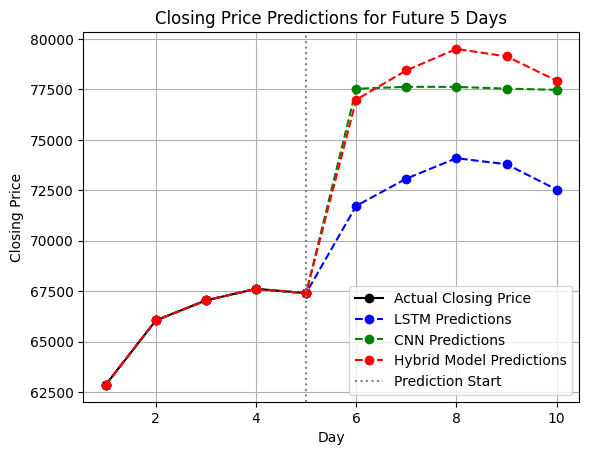

In [29]:
# Assuming 'y_test' contains the actual closing prices
last_5_actual = y_test[-5:]

# Convert predictions to a flat array if they aren't already
future_lstm_predictions = np.array(future_lstm_predictions).flatten()
future_cnn_predictions = np.array(future_cnn_predictions).flatten()
future_hybrid_predictions = np.array(future_hybrid_predictions).flatten()

# Extend the range for plotting (for 10 days: last 5 actual + next 5 predictions)
days = range(1, 11)  # Total 10 days (5 actual + 5 future)

# Combine the actual last 5 days with the predicted 5 days for each model
actual_and_lstm = np.concatenate([last_5_actual, future_lstm_predictions])
actual_and_cnn = np.concatenate([last_5_actual, future_cnn_predictions])
actual_and_hybrid = np.concatenate([last_5_actual, future_hybrid_predictions])

# Plot the actual closing prices (first 5 days)
plt.plot(days[:5], last_5_actual, label='Actual Closing Price', marker='o', color='black')

# Plot the predictions starting from day 6 to day 10
plt.plot(days, actual_and_lstm, label='LSTM Predictions', marker='o', linestyle='--', color='blue')
plt.plot(days, actual_and_cnn, label='CNN Predictions', marker='o', linestyle='--', color='green')
plt.plot(days, actual_and_hybrid, label='Hybrid Model Predictions', marker='o', linestyle='--', color='red')

# Add titles and labels
plt.title('Closing Price Predictions for Future 5 Days')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.axvline(x=5, linestyle=':', color='gray', label='Prediction Start')  # Line to separate actual from predicted
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
